#  Extracting text features

In [95]:
# Imports
import os
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import json

# matplotlib and seaborn for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline  
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [96]:
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import re
import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [97]:
def walk_up_folder(path, depth=1):
    """
    Helper method to navigate the file system and get to the file location
    """
    _cur_depth = 1        
    while _cur_depth < depth:
        path = os.path.dirname(path)
        _cur_depth += 1
    return path

In [5]:
from gensim.parsing import PorterStemmer
global_stemmer = PorterStemmer()
 
class StemmingHelper(object):
    """
    Class to aid the stemming process - from word to stemmed form,
    and vice versa.
    The 'original' form of a stemmed word will be returned as the
    form in which its been used the most number of times in the text.
    """
 
    #This reverse lookup will remember the original forms of the stemmed
    #words
    word_lookup = {}
 
    @classmethod
    def stem(cls, word):
        """
        Stems a word and updates the reverse lookup.
        """
 
        #Stem the word
        stemmed = global_stemmer.stem(word)
 
        #Update the word lookup
        if stemmed not in cls.word_lookup:
            cls.word_lookup[stemmed] = {}
        cls.word_lookup[stemmed][word] = (
            cls.word_lookup[stemmed].get(word, 0) + 1)
 
        return stemmed
 
    @classmethod
    def original_form(cls, word):
        """
        Returns original form of a word given the stemmed version,
        as stored in the word lookup.
        """
 
        if word in cls.word_lookup:
            return max(cls.word_lookup[word].keys(),
                       key=lambda x: cls.word_lookup[word][x])
        else:
            return word

In [98]:
SH=StemmingHelper()
SH.stem("applies")

'appli'

In [7]:
data_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/product_desc_only.txt')
categories_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/product_categories.txt')

In [8]:
def loadDocument(filepath):
    """
    Load the cleaned data into a list for vectorizers
    :param filepath: Read all files in this location
    :return: Return a list of all the documents' contents
    """
    print("Loading document from processed files")
    with open(filepath, 'r', encoding="utf-8") as doc:
        content = doc.read()
    return content

In [126]:
documents = loadDocument(data_path)

Loading document from processed files


In [127]:
documents = documents.split('\n\n')

In [128]:
remove = ['°', "'",'ß', '_', '|', 'ü','=', '®', 'ù', 'ç', 'à', '-', '”', '/', 'é', '`', 'ô', 'ê', '—', '–', 'ö', '’', '~', 'î', '.', 'â', 'œ', ',', '*', '\ufeff', ':', 'ï', 'è', 'ä', '･', '™', 'û']

In [40]:
def b(text):
    for ch in remove:
        if ch in text:
            text = text.replace(ch,"")
    return text

In [129]:
len(documents)

1000

In [130]:
documents

["supersoft speckled french terry makes this (tush covering!) turtleneck-sweatshirt hybrid the layering piece you'll want to wear to the gym, to lunch, to, well, everywhere this winter. loose fit. body length: 27 1/2. cotton. import.",
 'consider this embroidered layer your new dressy sweatshirt this winter. slim fit. body length: 24. cotton. import.',
 "slim american pima cotton oxford shirt with mechanical stretch at j.crew and see the entire selection of men's casual shirts. free shipping available.",
 "off-the-shoulder foldover top at j.crew and see the entire selection of women's knits. free shipping available.",
 "ruffle plunge v-neck one-piece swimsuit at j.crew and see the entire selection of women's swimwear. free shipping available.",
 "strappy knit midi dress at j.crew and see the entire selection of women's swimwear. free shipping available.",
 "mixed stripe t-shirt at j.crew and see the entire selection of women's knits. free shipping available.",
 'made from supersoft slu

In [131]:
# Replacing missing values with unknown
for idx,desc in enumerate(documents):
    if desc=='':
        print(idx)
        documents[idx] = "UNK" 

116
200
227
231
234
264
283
284
287
293
294
299
310
311
324
333
340
356
365
391
392
393
394
395
404
409
444
453
454
502
670
715
718
748
749
760
769
802
903
929
940
943
945


In [44]:
documents[116]

'UNK'

In [132]:
sent = "this is a foo bar®, bar black sheeps."
stop = stopwords.words('english') + list(string.punctuation)
[SH.stem(i) for i in word_tokenize(b(sent).lower()) if i not in stop]

['foo', 'bar', 'bar', 'black', 'sheep']

In [179]:
for idx,sent in enumerate(documents):
    documents[idx]=" ".join([SH.stem(i) for i in word_tokenize(b(sent).lower()) if i not in stop]).replace("'s","")

In [180]:
documents

['supersoft speckl french terri make tush cover turtlenecksweatshirt hybrid layer piec want wear gym lunch well everywh winter loo fit bodi length 27 12 cotton import',
 'consid embroid layer new dressi sweatshirt winter slim fit bodi length 24 cotton import',
 'slim american pima cotton oxford shirt mechan stretch jcrew see entir select men casual shirt free ship avail',
 'offtheshould foldov top jcrew see entir select women knit free ship avail',
 'ruffl plung vneck onepiec swimsuit jcrew see entir select women swimwear free ship avail',
 'strappi knit midi dress jcrew see entir select women swimwear free ship avail',
 'mix stripe tshirt jcrew see entir select women knit free ship avail',
 'made supersoft slub cotton cut slightli slouchi fit tshirt total summer must made bunch color feel free stock bodi length front 22 34 back 24 34 cotton machin wash import',
 'easi heather tshirt cute tieback detail make great gift mom roommat sisterinlaw get idea slim fit bodi length 23 cottonpoly

In [181]:
sentences=[ sent.split() for sent in documents]

In [182]:
counts = Counter()
#words = re.compile(r'\w+')
for sentence in sentences:
    counts.update(sentence)


In [183]:
counts.most_common(20)

[('select', 576),
 ('see', 569),
 ('avail', 564),
 ('jcrew', 558),
 ('ship', 553),
 ('entir', 549),
 ('free', 542),
 ('women', 443),
 ('de', 170),
 ('cotton', 167),
 ('shirt', 167),
 ('import', 144),
 ('wash', 144),
 ('dress', 137),
 ('size', 130),
 ('fit', 119),
 ('top', 118),
 ('made', 116),
 ('pant', 91),
 ('perfect', 91)]

In [112]:
# This was previous, without some manual preprocessing
counts.most_common(20)

[('women', 844),
 ('j', 580),
 ('select', 576),
 ('see', 569),
 ('avail', 564),
 ('shop', 561),
 ('crew', 561),
 ('ship', 554),
 ('entir', 549),
 ('free', 542),
 ('shirt', 219),
 ('cotton', 202),
 ('de', 170),
 ('wash', 157),
 ('import', 137),
 ('dress', 137),
 ('men', 136),
 ('size', 130),
 ('fit', 130),
 ('top', 121)]

In [184]:
vocab_size = len(counts)
vocab_size

4691

In [140]:
numTopics =11
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=vocab_size, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

# Running
print("Running Latent Dirichlet Allocation")
t0 = time.time()
lda = LatentDirichletAllocation(n_topics=numTopics, max_iter=5, learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf)
t1 = time.time()
print("Seconds for LDA: %.3f"%(t1 - t0))

Running Latent Dirichlet Allocation
Seconds for LDA: 0.923


In [141]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=11, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [146]:
tfidf_vectorizer = TfidfVectorizer(norm='l2',max_df=0.95, min_df=2, max_features=vocab_size, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# Running
print("Running Non-negative Matrix Factorization")
t0 = time.time()
nmf = NMF(n_components=numTopics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
t1 = time.time()
print("Seconds for NMF: %.3f"%(t1 - t0))

Running Non-negative Matrix Factorization
Seconds for NMF: 0.122


In [147]:
tfidf

<1000x1899 sparse matrix of type '<class 'numpy.float64'>'
	with 17552 stored elements in Compressed Sparse Row format>

In [152]:
# create dictionary to find a tfidf word each word
word2tfidf = tfidf_vectorizer.idf_
word2tfidf.shape

(1899,)

In [79]:
#tfidf=tfidf.todense()

In [90]:
tfidf

<1000x2012 sparse matrix of type '<class 'numpy.float64'>'
	with 17546 stored elements in Compressed Sparse Row format>

In [91]:
tfidf.shape

(1000, 2012)

In [92]:
tfidfmatrix = np.squeeze(tfidf.toarray())

In [93]:
tfidfmatrix.shape

(1000, 2012)

In [94]:
type(tfidfmatrix)

numpy.ndarray

In [60]:
nmf

NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5,
  max_iter=200, n_components=11, random_state=1, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [61]:
def display(model, feature_names, num_to_display):
    """
     Function to display the topics by their top words
    :param model:
    :param feature_names:
    :param num_to_display:
    :return:
    """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_to_display - 1:-1]]))

In [62]:
def save_fig(directory, fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    Method to save plots to the directory
    :param directory:
    :param fig_id:
    :param tight_layout:
    :param fig_extension:
    :param resolution:
    :return:
    """
    path = os.path.join(directory, fig_id + "." + fig_extension)
    print("Saving figure : " + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [63]:
img_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'static/plots')
if not os.path.exists(img_path):
    os.makedirs(img_path)


In [64]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from itertools import cycle, islice

num_clusters = 11
num_seeds = 11
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2


# tf_idf_vectorizer = TfidfVectorizer(analyzer="word", use_idf=True, smooth_idf=True, ngram_range=(2, 3))
# tf_idf_matrix = tf_idf_vectorizer.fit_transform(texts_list)

# create k-means model with custom config
clustering_model = KMeans(n_clusters=num_clusters,max_iter=max_iterations,precompute_distances="auto", n_jobs=-1)

labels = clustering_model.fit_predict(tfidf)
# print labels
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(labels) + 1))))
X = tfidf.todense()

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print reduced_data

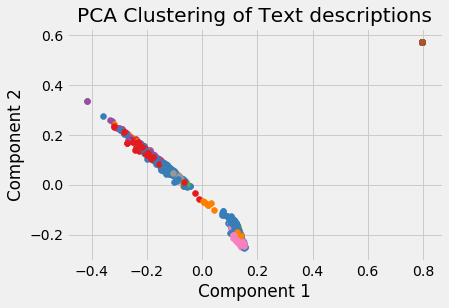

Saving figure : PCA2d


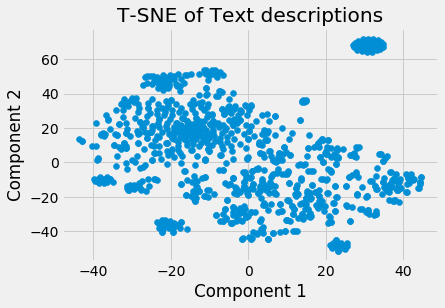

Saving figure : t-SNE2d


In [65]:
fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    # print instance, index, labels[index]
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = colors[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("PCA Clustering of Text descriptions")
plt.show()
save_fig(img_path,"PCA2d",False)


# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("T-SNE of Text descriptions")
plt.show()
save_fig(img_path,"t-SNE2d",False)


Saving figure : PCA3d


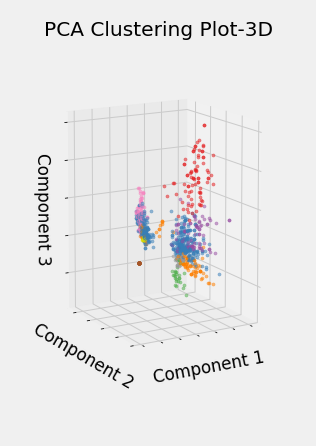

In [66]:
from mpl_toolkits.mplot3d import Axes3D
pca_num_components = 3
tsne_num_components = 3
reduced_data3 = PCA(n_components=pca_num_components).fit_transform(X)
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=10, azim=60)
for index, instance in enumerate(reduced_data):
    pca_comp_1, pca_comp_2,pca_comp3 = reduced_data3[index]
    color = colors[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2,pca_comp3, c=color,alpha=0.5, s=10)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('PCA Clustering Plot-3D')
ax.dist = 12
save_fig(img_path,"PCA3d",False)

Saving figure : T-SNE3d


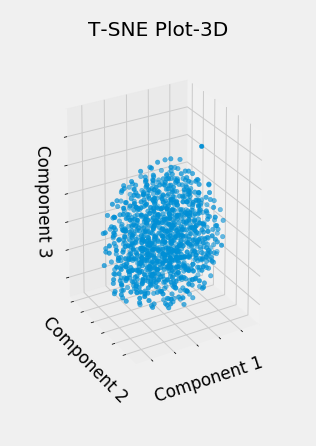

In [67]:
# t-SNE plot
embeddings = TSNE(n_components=tsne_num_components)
Y = embeddings.fit_transform(X)
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=20, azim=60)
ax.scatter(Y[:, 0], Y[:, 1],Y[:, 2], cmap=plt.cm.Spectral)
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('T-SNE Plot-3D')
ax.dist = 12
save_fig(img_path,"T-SNE3d",False)

In [68]:
len(labels)

1000

In [69]:
labels

array([ 3,  3,  7,  5,  1,  1,  5,  3,  3,  3,  5,  5,  5,  5,  5,  3,  5,
        5,  5,  0,  0,  0,  0,  1,  1,  5,  1,  3,  1,  1,  1,  1,  3,  1,
        1,  1,  1,  1,  9,  1,  1,  1,  3,  5,  5,  1,  1,  1,  1,  1,  0,
        0,  8,  8,  8,  6,  9,  9,  9,  9,  9,  9,  9,  5,  9,  9,  5,  9,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  7,  7,  7,  7,  9,  9,
        7, 10,  9,  3,  7,  3,  7,  7,  7,  3,  8,  5,  3,  5,  5,  1,  1,
        3,  9,  1,  3,  5,  1,  5,  1,  1,  1,  5,  1,  2,  2,  4,  5,  5,
        5,  5,  5,  5,  3,  0,  0,  0,  0,  0,  5,  5,  9,  5,  5,  5,  5,
        5,  5,  0,  0,  0,  0,  0,  0,  0,  0,  9, 10,  9,  9,  3,  5,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  3,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  3,  5,  9,  9,  3,  9,
        3,  9,  6,  9,  9,  9,  9,  9,  9,  9,  0,  9,  9,  4,  7,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10,  9,  3,  9

In [70]:
label_path = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/labeltfidf.txt')

In [71]:
# Storing the labels into a separate file
with open(label_path, "w", encoding='utf-8') as target:
    for _ in range(len(labels)):
        target.write(str(labels[_]))
        target.write("\n")

In [72]:
display(lda,tf_feature_names,100)

Topic 0:
unk und leather size mit inhalt pflege fits heel nur abwischen du das details synthetic upper measurements lining italy true die closure aus taken pom sole im handmade description leg cm der italian für spandex nylon grösse ist einen microfiber raw verschiedene metalle waistband eine zipper 75 perfekt kannst stoppuhr oder von anzeige best design cut patented opening verpasst india zum look deinen boot shaft strap heeled acryl hand den dieser platform bucket adjustable bag interior mini wash 24 note batterie cotton vegetable tanned 200 featuring uhr nicht wasserdicht hintergrundbeleuchtung item ein diesen des 11 28 inspiration plastik box sind
Topic 1:
crew selection entire free available shipping women shirt shirts men petite swimwear girls tall knits button dresses dress stripe cotton sleeve earrings slim short bikini pant stretch perfect pants tie bags linen print jacket floral jackets accessories cew ruffle striped footwear popover gold long piece fine plated 14k demi neck 

# Word Vector Representations

In [185]:
sentences

[['supersoft',
  'speckl',
  'french',
  'terri',
  'make',
  'tush',
  'cover',
  'turtlenecksweatshirt',
  'hybrid',
  'layer',
  'piec',
  'want',
  'wear',
  'gym',
  'lunch',
  'well',
  'everywh',
  'winter',
  'loo',
  'fit',
  'bodi',
  'length',
  '27',
  '12',
  'cotton',
  'import'],
 ['consid',
  'embroid',
  'layer',
  'new',
  'dressi',
  'sweatshirt',
  'winter',
  'slim',
  'fit',
  'bodi',
  'length',
  '24',
  'cotton',
  'import'],
 ['slim',
  'american',
  'pima',
  'cotton',
  'oxford',
  'shirt',
  'mechan',
  'stretch',
  'jcrew',
  'see',
  'entir',
  'select',
  'men',
  'casual',
  'shirt',
  'free',
  'ship',
  'avail'],
 ['offtheshould',
  'foldov',
  'top',
  'jcrew',
  'see',
  'entir',
  'select',
  'women',
  'knit',
  'free',
  'ship',
  'avail'],
 ['ruffl',
  'plung',
  'vneck',
  'onepiec',
  'swimsuit',
  'jcrew',
  'see',
  'entir',
  'select',
  'women',
  'swimwear',
  'free',
  'ship',
  'avail'],
 ['strappi',
  'knit',
  'midi',
  'dress',
  'jc

In [188]:
from sklearn.feature_extraction.text import TfidfTransformer
cv = CountVectorizer()
# convert text data into term-frequency matrix
data = cv.fit_transform([" ".join(sent) for sent in sentences])

tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))

# for word, score in word2tfidf.items():
#     print(word, score)

In [203]:
len(word2tfidf)

4669

In [195]:
import gensim
from gensim import models

In [108]:
lang_file = os.path.join(walk_up_folder(os.getcwd(), depth=1),'Data/embeddings.txt')

In [200]:
print("Saving Language model")
model_eng = models.Word2Vec(sentences, size=300, window=5, min_count=5, workers=4)
model_eng.save(lang_file)
print("Word2Vec embeddings complete")

Saving Language model
Word2Vec embeddings complete


In [158]:
model_eng["the"].shape

(256,)

In [191]:
documents[0]

'supersoft speckl french terri make tush cover turtlenecksweatshirt hybrid layer piec want wear gym lunch well everywh winter loo fit bodi length 27 12 cotton import'

In [193]:
sentences[0]

['supersoft',
 'speckl',
 'french',
 'terri',
 'make',
 'tush',
 'cover',
 'turtlenecksweatshirt',
 'hybrid',
 'layer',
 'piec',
 'want',
 'wear',
 'gym',
 'lunch',
 'well',
 'everywh',
 'winter',
 'loo',
 'fit',
 'bodi',
 'length',
 '27',
 '12',
 'cotton',
 'import']

In [201]:
for word in sentences[0]:
    if word not in model_eng.wv.vocab:
        print("gensim",word)
    if word not in word2tfidf:
        print("tfidf",word)

gensim speckl
gensim tush
gensim turtlenecksweatshirt
gensim hybrid
gensim gym
gensim lunch
gensim everywh


In [202]:
len(model_eng.wv.vocab)

880

In [210]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.vocab and word in word2tfidf.keys()]
    weights=[word2tfidf[word] for word in doc]
    return np.average(word2vec_model[doc], axis=0,weights=weights)


In [212]:
document_vector(model_eng, sentences[0]).shape

(300,)

In [216]:
sentences[300]

['topo', 'roverpack']

In [219]:
x=[]
for idx,sentence in enumerate(sentences): #look up each doc in model
    
    try:
        x.append(document_vector(model_eng, sentence))
    except:
        print(idx)
        x.append(np.zeros(300,))


# In[11]:

text_feats = np.array(x) #list to array

300


In [221]:
text_feats.shape

(1000, 300)

In [222]:
from sklearn.externals import joblib
joblib.dump(text_feats,'text_feats.pkl')

['text_feats.pkl']

In [223]:
new_feats = joblib.load('text_feats.pkl')

In [224]:
text_feats[0]==new_feats[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,